# Figure 3 - TCC I for italy

With this jupyter notebook you can generates Figure 3 of:  van der Most et al. Temporally compounding energy droughts in European electricity systems with hydropower

In [2]:
# General packages
import os
from calendar import monthrange
import calendar
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

# Plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.io.shapereader as shapereader
from matplotlib.patches import Rectangle
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import string


# Set matplotlib inline for Jupyter Notebooks
%matplotlib inline

# Update matplotlib parameters
mpl.rcParams.update(mpl.rcParamsDefault)

# Set the font to sans-serif, preferring Helvetica or Arial
mpl.rcParams['font.sans-serif'] = ["Helvetica", "Arial", "sans-serif"]

# Set the default font type to sans-serif
mpl.rcParams['font.family'] = 'sans-serif'

# Set the maximum font size to 7pt
mpl.rcParams['font.size'] = 5
mpl.rcParams['legend.fontsize'] = 5

# Set the font size for axis labels
mpl.rcParams['axes.labelsize'] = 7  # Change this value to your preferred size

# Set the minimum font size for smaller text elements, like tick labels
mpl.rcParams['xtick.labelsize'] = 5
mpl.rcParams['ytick.labelsize'] = 5

# set figure linewidths
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.6
mpl.rcParams['ytick.major.width'] = 0.6
mpl.rcParams['xtick.minor.width'] = 0.4
mpl.rcParams['ytick.minor.width'] = 0.4

## data and settings


In [15]:
# points of interest
pois = {
       'ITA':(-90,-60),
       }

colors_seasons = {
    'winter':'#0000FF',
    'summer': '#ff9412',#'#FFB14E',
    'all':'#E8246F',
}

extension = 1200
# input folder
ifolder = 'data_for_images/'
# energy data
data = pd.read_csv(ifolder+'fig3_events_reservoir_ITA.csv', index_col=0)
demdata = pd.read_csv(ifolder+'fig3_events_demand_ITA.csv', index_col=0)
resdata = pd.read_csv(ifolder+'fig3_events_residual_ITA.csv', index_col=0)
Eindata = pd.read_csv(ifolder+'fig3_events_inflow_ITA.csv', index_col=0)
Eoutdata = pd.read_csv(ifolder+'fig3_events_outflow_ITA.csv', index_col=0)
# climate data
psl = xr.open_dataset(ifolder+'fig3_psl.nc')
tas = xr.open_dataset(ifolder+'fig3_tas.nc')
mrro = xr.open_dataset(ifolder+'fig3_mrro.nc')
# risk ratio data
dfhm = pd.read_csv(ifolder+ f'rr_summer_after_low_mrro_poi_LENTIS_PD_02_v4.csv',index_col=0)
dfhm = dfhm.drop('CHE')
dfSI = pd.read_csv(ifolder + f'statistical_significant_rr_summer_after_low_mrro_poi_LENTIS_PD_02_v4.csv',index_col=0)
dfSI = dfSI.drop('CHE')

# make main plot

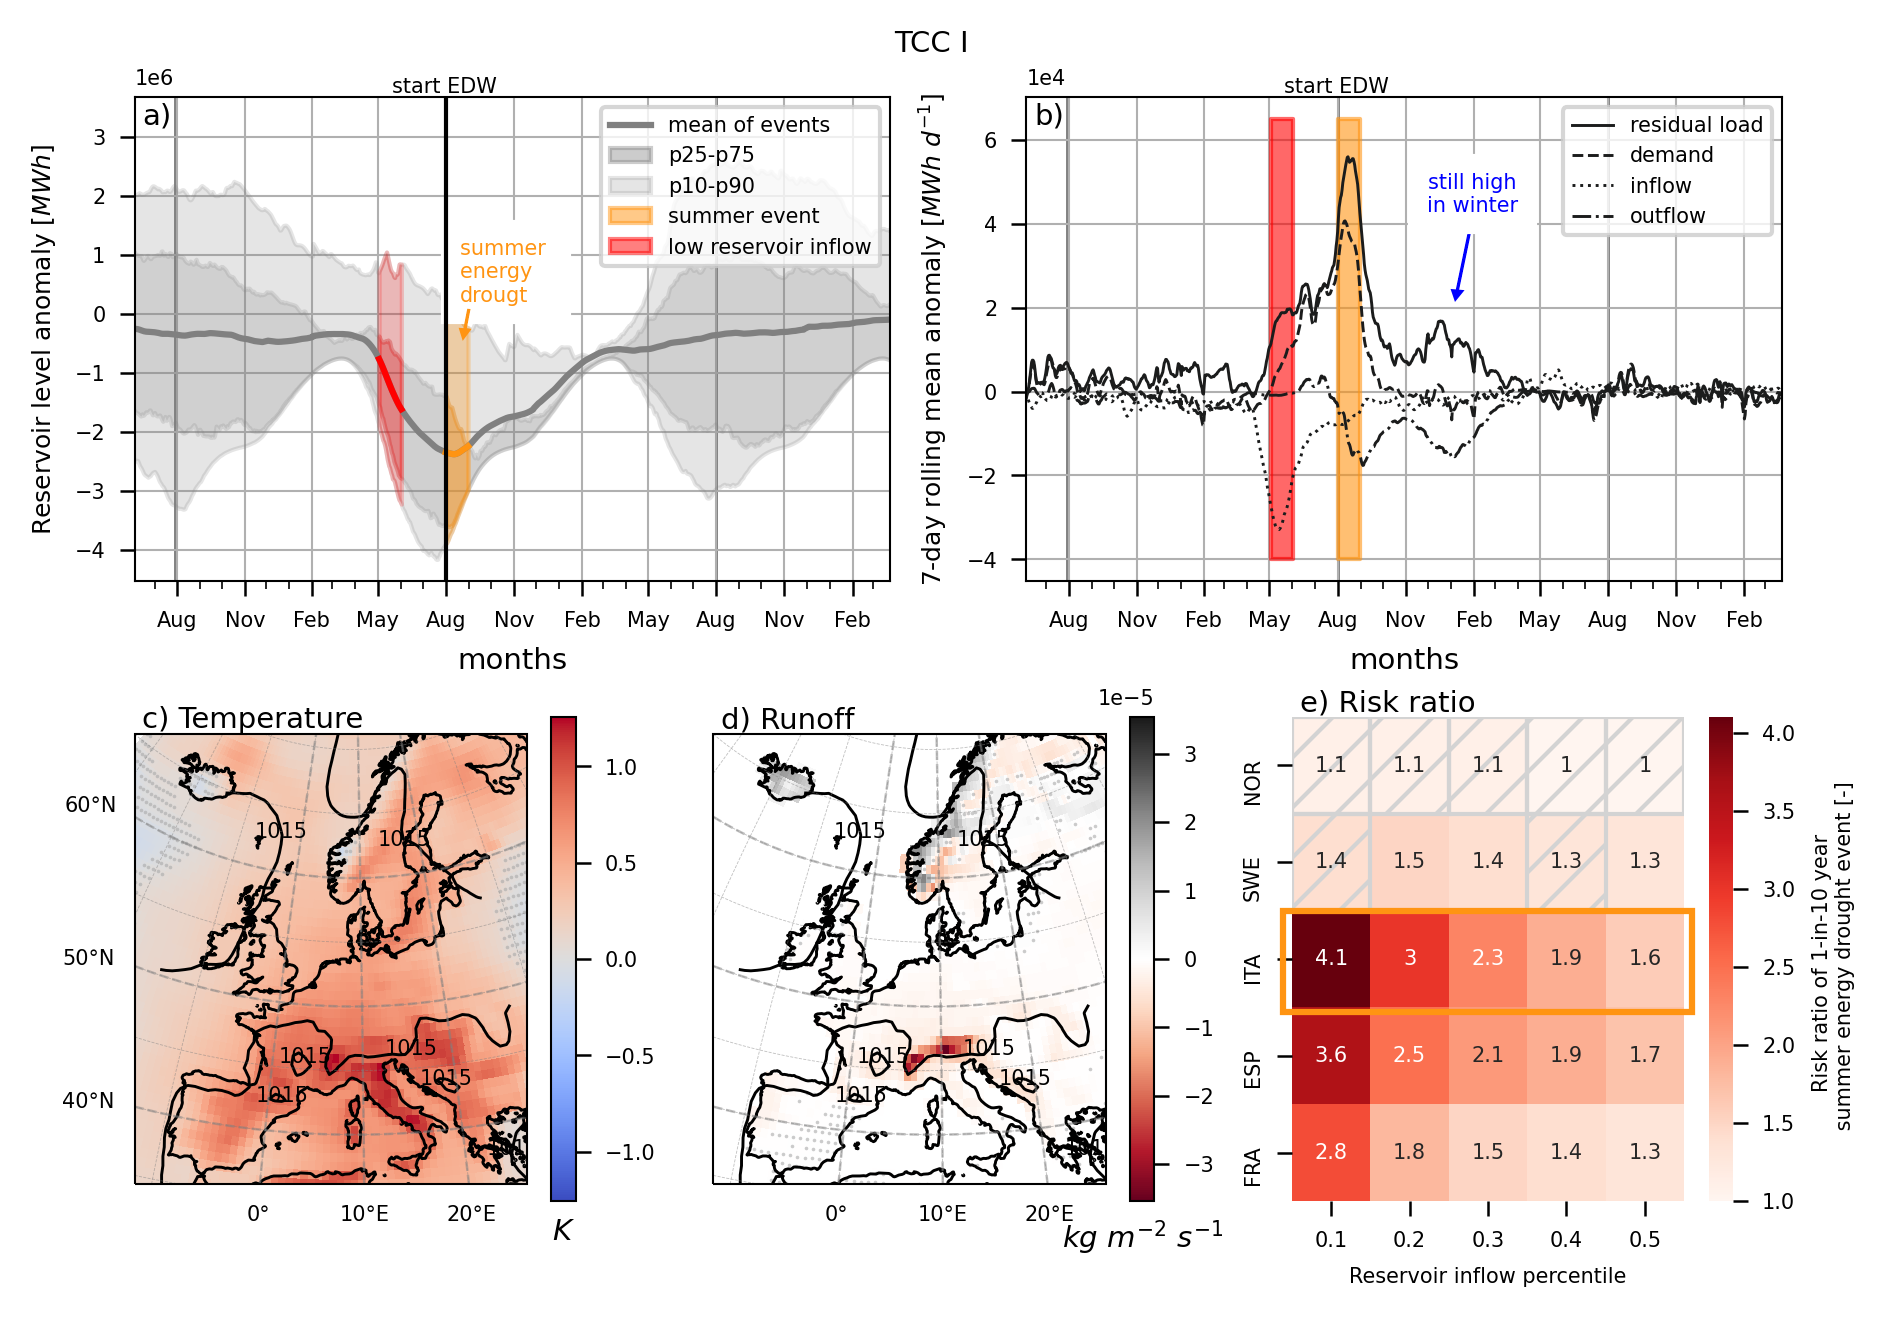

In [20]:
# Define colormap settings for variables
cmaps = {'tas': 'coolwarm', 'mrro': 'RdGy'}

# Define contour levels for plotting
levelsp = np.arange(990, 1030, 2.5)

# Plot country border
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'
shpfilename = shapereader.natural_earth(resolution, category, name)
df = gpd.read_file(shpfilename)

# Define figure size in millimeters and convert to inches
width_mm = 180
height_mm = (9.5 / 15) * 180
width_in = width_mm / 25.4
height_in = height_mm / 25.4

# Create figure and subplot grid
fig = plt.figure(figsize=(width_in, height_in), dpi=300)
fig.suptitle('TCC I', fontsize=7)  # Add a title to the figure

fs = 5  # Font size for plots

# Define subplots layout
ax0 = fig.add_subplot(2, 2, 1)
ax01 = fig.add_subplot(2, 2, 2)
ax1 = fig.add_subplot(2, 3, 4, projection=ccrs.EuroPP())
ax2 = fig.add_subplot(2, 3, 5, projection=ccrs.EuroPP())
ax3 = fig.add_subplot(2, 3, 6)

country = 'ITA'  # Define the country for data analysis

# Labels and styles for different data series
labels = ['residual load', 'demand', 'inflow', 'outflow']
ls = ['solid', 'dashed', 'dotted', 'dashdot']
handles_list = []
labels_list = []

# Loop through each subplot and plot the data series
for i, (a, d) in enumerate(zip((ax0, ax01, ax01, ax01, ax01), (data, resdata, demdata, Eindata, Eoutdata))):
    dft2 = d
    dft2['date_idx'] = np.arange(0, len(dft2)) - extension  # Create a date index for the dataset
    dft2 = dft2.set_index('date_idx')  # Set the date index
    dft2 = dft2.rolling(7).mean().shift(-3)  # Apply a rolling mean and shift to get 7-day values
    co = 'grey'
    dft2.mean(axis=1).plot(legend=False, ax=a, label=labels[i - 1], linestyle=ls[i - 1], color='#1b1c1c', alpha=1, linewidth=0.7)
    
    # Specific settings and overlays for the first subplot (ax0)
    if a == ax0:
        co = 'grey'
        dft2.mean(axis=1).plot(legend=False, ax=a, color=co)
        handles_list.append(mlines.Line2D([], [], color='grey', label='mean of events'))
        labels_list.append('mean of events')
        
        a.fill_between(dft2.index, dft2.quantile(0.75, axis=1), dft2.quantile(0.25, axis=1), color=co, alpha=0.2)
        fill1_handle = mpatches.Patch(color='grey', alpha=0.4)
        handles_list.append(fill1_handle)
        labels_list.append('p25-p75')
        
        a.fill_between(dft2.index, dft2.quantile(0.9, axis=1), dft2.quantile(0.1, axis=1), color=co, alpha=0.2)
        fill2_handle = mpatches.Patch(color='grey', alpha=0.2)
        handles_list.append(fill2_handle)
        labels_list.append('p10-p90')
        
        co = colors_seasons['summer']
        dft3 = dft2.loc[0:30]
        dft3.mean(axis=1).plot(legend=False, ax=a, color=co)
        a.fill_between(dft3.index, dft3.quantile(0.75, axis=1), dft3.quantile(0.25, axis=1), color=co, alpha=0.3)
        a.fill_between(dft3.index, dft3.quantile(0.9, axis=1), dft3.quantile(0.1, axis=1), color=co, alpha=0.3)

        fill2_handle = mpatches.Patch(color=co, alpha=0.5)
        handles_list.append(fill2_handle)
        labels_list.append('summer event')
        
        co = 'red'
        dft3 = dft2.loc[pois[country][0]:pois[country][1]]
        dft3.mean(axis=1).plot(legend=False, ax=a, color=co)
        a.fill_between(dft3.index, dft3.quantile(0.75, axis=1), dft3.quantile(0.25, axis=1), color=co, alpha=0.2)
        a.fill_between(dft3.index, dft3.quantile(0.9, axis=1), dft3.quantile(0.1, axis=1), color=co, alpha=0.2)
        
        fill2_handle = mpatches.Patch(color=co, alpha=0.5)
        handles_list.append(fill2_handle)
        labels_list.append('low reservoir inflow')
    else:
        co = 'red'
        a.fill_between([pois[country][0], pois[country][1]], -40000, 65000, color=co, alpha=0.2)
        co = colors_seasons['summer']
        a.fill_between([0, 30], -40000, 65000, color=co, alpha=0.2)

    a.set_ylabel('7-day rolling mean anomaly [$MWh$ $d^{-1}$]', fontsize=6)
    a.set_xlabel('time [days from event]')
    a.set_axisbelow(True)
    a.grid()

# Remove duplicate handles and labels
unique_handles_labels = dict(zip(labels_list, handles_list))
unique_handles = list(unique_handles_labels.values())
unique_labels = list(unique_handles_labels.keys())

# Create the legend
ax0.legend(unique_handles, unique_labels, fontsize=5)
ax01.legend(fontsize=5)

# Set monthly ticks for x-axis
mls = [monthrange(2005, i)[1] for i in range(1, 13)]
mnms = [calendar.month_abbr[i] for i in range(1, 13)]
pos = np.cumsum([0] + mls + mls + mls)
neg = np.cumsum([-x for x in mls] + [-x for x in mls] + [-x for x in mls])[::-1]
ticks = np.concatenate([neg, pos])[:-1]
ticks = ticks - 212
names = mnms + mnms + mnms + mnms + mnms + mnms

for a in [ax0, ax01]:
    a.set_xticks(ticks, minor=True)
    a.set_xticks(ticks[1::3])
    a.set_xticklabels(names[1::3])
    for y in [-2, -1, 0, 1, 2]:
        a.axvline(y * 365, color='grey', linewidth=0.7, zorder=-1)
    a.set_xlim(-420, 600)
    a.set_xlabel('months')
    a.ticklabel_format(style='sci', scilimits=(-3, 4), axis='y')

ax0.set_ylabel('Reservoir level anomaly [$MWh$]')

# Add annotations and arrows for events
ax0.text(0.43, 0.57, 'summer \nenergy \ndrougt', fontsize=5, horizontalalignment='left', verticalalignment='bottom', transform=ax0.transAxes, color=colors_seasons['summer'], backgroundcolor='white', zorder=1)
ax0.arrow(0.442, 0.56, -0.005, -0.04, head_width=0.012, head_length=0.018, transform=ax0.transAxes, color=colors_seasons['summer'], linewidth=0.6, zorder=5)
ax0.text(0.41, 1, 'start EDW', horizontalalignment='center', verticalalignment='bottom', transform=ax0.transAxes, color='black')
ax0.axvline(0, color='black', linewidth=1, zorder=2)
ax01.text(0.41, 1, 'start EDW', horizontalalignment='center', verticalalignment='bottom', transform=ax01.transAxes, color='black')

# Define formatting function for contour labels
def fmt(x):
    s = f"{x:.0f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

# Plot sea level pressure contour lines
for ax in [ax1, ax2]:
    CS = ((psl['psl'].sel(lon=slice(-15, 28)) / 100).plot.contour(ax=ax, colors='black', levels=levelsp, add_colorbar=False, add_labels=False, linewidths=0.7, transform=ccrs.PlateCarree()))
    ax.clabel(CS, CS.levels[::1], inline=True, fmt=fmt, fontsize=5)

# Plot temperature anomalies
pcm = tas.tas.plot(ax=ax1, cmap=cmaps['tas'], add_colorbar=False, add_labels=False, transform=ccrs.PlateCarree())
gl0 = ax1.gridlines(draw_labels=False, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
gl = ax1.gridlines(draw_labels=False, linewidth=0.6, color='gray', alpha=0.5, linestyle='--', x_inline=False)
gl.xlabel_style = {'size': 5, 'rotation': 0}
gl.ylabel_style = {'size': 5, 'rotation': 0}
gl.xlocator = plt.FixedLocator([0, 10, 20])
gl.ylocator = plt.FixedLocator([40, 50, 60])
gl.bottom_labels = True
gl.left_labels = True

# Highlight non-significant grid cells with grey dots
dft = tas.sign.to_dataframe().reset_index()
dft = dft.loc[dft.sign, :]
non_significant_lon = dft.lon.values
non_significant_lat = dft.lat.values
cs = ax1.scatter(non_significant_lon, non_significant_lat, color='darkgrey', s=3, marker='.', edgecolor=None, facecolor=None, transform=ccrs.PlateCarree(), alpha=0.6, lw=0)
ax1.coastlines(resolution='50m', linewidth=0.7)
cbar = plt.colorbar(pcm, ax=ax1, shrink=1)
cbar.ax.set_xlabel('$K$')
ax1.set_xlabel('Temperature anomalies')

# Plot runoff anomalies
pcm = mrro.mrro.plot(ax=ax2, cmap=cmaps['mrro'], add_colorbar=False, add_labels=False, transform=ccrs.PlateCarree())
gl0 = ax2.gridlines(draw_labels=False, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
gl = ax2.gridlines(draw_labels=False, linewidth=0.6, color='gray', alpha=0.5, linestyle='--',  x_inline=False)
gl.xlabel_style = {'size': 5, 'rotation': 0}
gl.ylabel_style = {'size': 5, 'rotation': 0}
gl.xlocator = plt.FixedLocator([0, 10, 20])
gl.ylocator = plt.FixedLocator([40, 50, 60])
gl.bottom_labels = True

# Highlight non-significant grid cells with grey dots
dft = mrro.sign.to_dataframe().reset_index()
dft = dft.loc[dft.sign, :]
non_significant_lon = dft.lon.values
non_significant_lat = dft.lat.values
cs = ax2.scatter(non_significant_lon, non_significant_lat, color='darkgrey', s=3, marker='.', edgecolor=None, facecolor=None, transform=ccrs.PlateCarree(), alpha=0.6, lw=0)
ax2.coastlines(resolution='50m', linewidth=0.7)
cbar = plt.colorbar(pcm, ax=ax2, shrink=1)
cbar.ax.set_xlabel('$kg$ $m^{-2}$ $s^{-1}$')
ax2.set_xlabel('Runoff anomalies')

# Plot heatmap for risk ratio data
dfhm = dfhm.round(1)
axhm = sns.heatmap(dfhm, annot=True, ax=ax3, cbar_kws={'label': 'Risk ratio of 1-in-10 year \n summer energy drought event [-]'}, cmap='Reds', annot_kws={"size": 5})

# Add statistical significance texture
for y in range(dfSI.shape[0]):
    for x in range(dfSI.shape[1]):
        if dfSI.iloc[y, x]:
            plt.gca().add_patch(plt.Rectangle((x, y), 1, 1, fill=False, hatch='//', edgecolor='lightgrey'))

axhm.figure.axes[-1].yaxis.label.set_size(fs)
axhm.set_xlabel('Reservoir inflow percentile', fontsize=5)

# Remove titles from subplots and add labels
for ax in [ax1, ax2, ax3]:
    ax.set_title(' ')

for n, (ax, title) in enumerate(zip([ax0, ax01, ax1, ax2, ax3], ['', '', ' Temperature', ' Runoff', ' Risk ratio'])):
    if ax == ax0:
        ax.text(0.01, 0.99, string.ascii_lowercase[n] + ')' + title, ha='left', va='top', transform=ax.transAxes, size=7)
    elif ax == ax01:
        ax.text(0.01, 0.99, string.ascii_lowercase[n] + ')' + title, ha='left', va='top', transform=ax.transAxes, size=7)
    elif ax == fig.axes[-1]:
        continue
    else:
        ax.text(0.02, 1, string.ascii_lowercase[n] + ')' + title, ha='left', va='bottom', transform=ax.transAxes, size=7)

# Add arrow and text to subplot
ax01.text(0.59, 0.8, 'still high\nin winter', ha='center', va='center', transform=ax01.transAxes, backgroundcolor='1', size=5, color=colors_seasons['winter'])
ax01.arrow(0.59, 0.75, -0.02, -0.15, head_width=0.013, head_length=0.018, transform=ax01.transAxes, color=colors_seasons['winter'], linewidth=0.6)

# Add rectangle to heatmap
ax = fig.add_subplot(2, 2, 4)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_zorder(1000)
ax.axis('off')
ax.add_patch(Rectangle((0.34, 0.39), 0.54, 0.21, fill=None, alpha=1, transform=ax.transAxes, color=colors_seasons['summer'], linewidth=1.5))

# Adjust subplot spacing and show the figure
fig.subplots_adjust(hspace=0.28, wspace=0.18)
plt.subplots_adjust(top=0.93)
plt.show()
